In [1]:
!git clone https://github.com/okg21/coup.git
!cd coup

Cloning into 'coup'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 260 (delta 148), reused 157 (delta 62), pack-reused 0
Receiving objects: 100% (260/260), 3.24 MiB | 4.45 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [3]:
#add /coup to path
import sys
sys.path.append('/content/coup')

In [4]:
# import statements
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import importlib
import wandb

import player
import rl_player
importlib.reload(player)
importlib.reload(rl_player)
from player import *
from rl_player import *

#get torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
NUM_GAMES = 100

def run_simulation(players, shuffle_turn_order=False, num_games=NUM_GAMES):
    winners = []

    for game_index in range(num_games):
        if shuffle_turn_order:
            random.shuffle(players)
        game = Game(players, debug=False)

        turn_count = 0
        while len(game.game_state['players']) > 1:
            game.simulate_turn()
            turn_count += 1
            if turn_count > 100:
                break
        winner = game.game_state['players'][0].name
        winners.append(winner)
    return winners

In [6]:
def train_agent(agent, env, num_episodes, max_steps, batch_size, reward_dict, update_freq, sample_freq, sp_update_freq=10,
                win_threshold=0.8, display_progress=False, save_model=False, player_types=[]):
    total_rewards = []
    win_rates = []
    best_winrate = 0.0

    for episode in tqdm(range(num_episodes), desc='Episode Loop'):
        initial_state = env.reset()
        state = initial_state
        done = False
        total_reward = 0
        step = 0

        while not done and step <= max_steps:
            # Environment stepping
            action, next_state, reward, done = env.step(reward_dict)

            # For adding experience
            agent.add_experience(state, action, reward, next_state, done)

            # Update the game state and history for the next iteration
            state = next_state
            total_reward += reward
            step += 1

        # Replaying experience
        if len(agent.replay_buffer) >= batch_size and step % update_freq == 0:
            agent.replay_experience(batch_size, agent.name)

        # Decay epsilon
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

        # Save the total reward for this episode
        total_rewards.append(total_reward)

        # Log the total reward for this episode
        wandb.log({"total_reward": total_reward})

        if display_progress and episode % sample_freq == 0:
            winners = run_simulation(env.players)
            win_pct = len([w for w in winners if w == agent.name]) / len(winners)

            # Log the win rate for this episode
            wandb.log({"win_rate": win_pct})
            win_rates.append(win_pct)

            if win_pct > best_winrate:
                # Save the model
                best_winrate = win_pct
                #agent.save_model('models/{0}-{1}-{2}'.format(len(env.players), num_episodes, ','.join(player_types)))
                wandb.save('models/{0}-{1}-{2}'.format(len(env.players), num_episodes, ','.join(player_types)))

            # Print win rates
            print(f"Episode {episode + 1}/{num_episodes} - Win Rate: {win_pct} - Epsilon: {agent.epsilon}")

            # If last sp_update_freq win rates are all over threshold, update the other players to main agent's weights
            if len(win_rates) >= sp_update_freq and all([w > win_threshold for w in win_rates[-sp_update_freq:]]):
                for player in env.players:
                    if player.agent is not None and player.name != agent.name:
                        # TO-DO: Maybe empty the replay buffer?
                        player.agent.model.load_state_dict(agent.model.state_dict())
                        player.agent.target_model.load_state_dict(agent.target_model.state_dict())
                        print(f"Updating {player.name} to {agent.name}'s weights")

    if display_progress:
        # Plot the win rate over time
        plt.plot([x * sample_freq + 1 for x in list(range(len(win_rates)))], win_rates, label="agent win rate")
        plt.plot([x * sample_freq + 1 for x in list(range(len(win_rates)))], [1 / len(env.players) for _ in range(len(win_rates))], label="expected win rate", linestyle='dashed')
        plt.legend()
        plt.title('Q-Learning win rate over time')
        plt.ylabel('win rate')
        plt.xlabel('number of episodes')
        plt.show()

    return total_rewards, win_rates

In [7]:
def self_play_training(n, reward_dict, learning_rate, gamma, epsilon_decay, h_dim, h_layers, tau,
                        buffer_size, num_episodes, batch_size, max_steps_per_episode,
                        update_freq, sample_freq, sp_update_freq, win_threshold, history_length=5, display_progress=True):

  action_dim = 5
  block_size = 2
  turn_dim = action_dim + n * 3 + block_size * 2
  state_dim = (10 + 11 * n) + (history_length * turn_dim)
  action_dim = 1 + 3 * n



  agent1 = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1', True, history_length=history_length,
                          epsilon_decay=epsilon_decay, h_dim= h_dim, h_layers=h_layers, tau=tau, buffer_size=buffer_size)

  agents = []
  for i in range(2, n+1):
    agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, f'Player {i}', False, history_length=history_length,
                          epsilon_decay=epsilon_decay,h_dim= h_dim, h_layers=h_layers, tau=tau, buffer_size=buffer_size)
    agents.append(agent)

  RLTRAINING_FUNCS = {
    'decision_fn': rltraining_decision,
    'block_fn': income_block,
    'dispose_fn': random_dispose,
    'keep_fn': random_keep
  }

  players = [Player('Player 1', RLTRAINING_FUNCS, agent1)]
  for i in range (2, n+1):
    players.append(Player(f'Player {i}', RLTRAINING_FUNCS, agents[i-2]))

  env = Environment('Player 1', players)


  total_rewards, win_rates = train_agent(
    agent1, env, num_episodes, max_steps_per_episode, batch_size, reward_dict,
    update_freq=update_freq, sample_freq=sample_freq, sp_update_freq=sp_update_freq, win_threshold=win_threshold,
    display_progress=display_progress
  )

  return total_rewards, win_rates


In [9]:
import wandb
wandb.init(project="coup-3-player-self-play")

sweep_config = {
    'method': 'random',  # Can be "grid", "random", "bayes"
    'metric': {
      'name': 'win_rate',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 1e-4,
            'max': 1e-2
        },
        'update_freq': {
            'values': [1, 16, 32, 64, 128]
        },
        'gamma': {
            'values': [0.95, 0.99, 0.999]
        },
        'epsilon_decay': {
            'min': 0.99,
            'max': 0.9999
        },
        'h_dim': {
            'values': [128, 256, 512, 1024]
        },
        'h_layers': {
            'values': [2, 3, 4, 5, 6]
        },
        'tau': {
            'min': 1e-4,
            'max': 1e-2
        },
        'batch_size': {
            'values': [32, 64, 128, 1024, 4096]
        },
        'history_length': {
            'values': [10, 20, 30, 40, 50]
        },
        'buffer_size': {
            'values': [1e4, 1e5, 1e6, 1e7, 1e8]
        },

        'COIN_VALUE': {
            'min': 0.1,
            'max': 0.7
        },
        'CARD_VALUE': {
            'min': 0.3,
            'max': 0.7
        },
        'CARD_DIVERSITY_VALUE': {
            'min': 0.0,
            'max': 0.3
        },
        'WIN_VALUE': {
            'min': 0.5,
            'max': 1.0
        },
    }
}

wandb: Currently logged in as: okg21. Use `wandb login --relogin` to force relogin


In [10]:
def train():
    # Initialize a new wandb run
    with wandb.init() as run:
        config = wandb.config

        reward_dict = {
            'COIN_VALUE': config.COIN_VALUE,
            'CARD_VALUE': config.CARD_VALUE,
            'CARD_DIVERSITY_VALUE': config.CARD_DIVERSITY_VALUE,
            'WIN_VALUE': config.WIN_VALUE
        }

        # Call your training function with wandb's config
        total_rewards, win_rates = self_play_training(
            n=3,
            reward_dict=reward_dict,
            learning_rate=config.learning_rate,
            gamma=config.gamma,
            epsilon_decay=config.epsilon_decay,
            h_dim=config.h_dim,
            h_layers=config.h_layers,
            tau=config.tau,
            buffer_size=config.buffer_size,
            num_episodes=1000,
            batch_size=config.batch_size,
            max_steps_per_episode=100,
            update_freq=config.update_freq,
            sp_update_freq=5,
            sample_freq=100,
            win_threshold=0.9,
            history_length=config.history_length,
            display_progress=True
        )

        # Log maximum and average values of total_rewards
        wandb.log({"max_total_reward": max(total_rewards)})
        wandb.log({"avg_total_reward": sum(total_rewards) / len(total_rewards)})

        # Log maximum and average values of win_rates
        wandb.log({"max_win_rate": max(win_rates)})
        wandb.log({"avg_win_rate": sum(win_rates) / len(win_rates)})



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 1ijcsiwv
Sweep URL: https://wandb.ai/okg21/coup-3-player-self-play/sweeps/1ijcsiwv


Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 300, in check_internal_messages
    self._loop_check_status(
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 224, in _loop_check_status
    local_handle = request()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/interface.py", line 764, in deliver_internal_messages
    return self._deliver_internal_messages(internal_message)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/interface_shared.py", line 490, in _deliver_internal_messages
    return self._deliver_record(record)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/interface_shared.py", line 437, in _deliver_r

Episode Loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1/1000 - Win Rate: 0.35 - Epsilon: 0.9956156557239448
Episode 101/1000 - Win Rate: 0.23 - Epsilon: 0.6415986326581747
Episode 201/1000 - Win Rate: 0.16 - Epsilon: 0.41346156326711825
Episode 301/1000 - Win Rate: 0.16 - Epsilon: 0.2664445583230644
Episode 401/1000 - Win Rate: 0.22 - Epsilon: 0.1717032705507083
Episode 501/1000 - Win Rate: 0.16 - Epsilon: 0.11064971003109304
Episode 601/1000 - Win Rate: 0.23 - Epsilon: 0.07130532977442151
Episode 701/1000 - Win Rate: 0.21 - Epsilon: 0.04595086650304143
Episode 801/1000 - Win Rate: 0.19 - Epsilon: 0.02961184162614674
Episode 901/1000 - Win Rate: 0.25 - Epsilon: 0.019082581705699913


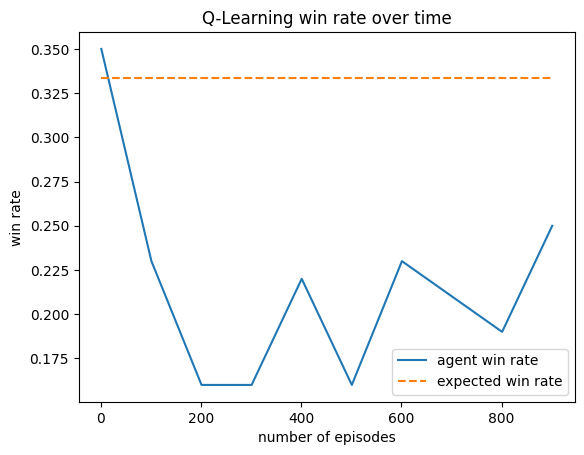

avg_total_reward,▁
avg_win_rate,▁
max_total_reward,▁
max_win_rate,▁
total_reward,▂▅▅▆▅▅▂▂▂▂▂▂▂▂▇▂▂▂▆█▁▂▁▁▁▁▁▁██▁█▁▁▁▁▁▁▁█
win_rate,█▄▁▁▃▁▄▃▂▄
avg_total_reward,0.57911
avg_win_rate,0.216
max_total_reward,17.52843
max_win_rate,0.35
total_reward,12.65476


wandb: Agent Starting Run: y2hzi3ou with config:
wandb: 	CARD_DIVERSITY_VALUE: 0.10269884105615736
wandb: 	CARD_VALUE: 0.465062760453368
wandb: 	COIN_VALUE: 0.6814490028342359
wandb: 	WIN_VALUE: 0.7643801853481313
wandb: 	batch_size: 128
wandb: 	buffer_size: 10000
wandb: 	epsilon_decay: 0.9985812504192332
wandb: 	gamma: 0.99
wandb: 	h_dim: 512
wandb: 	h_layers: 4
wandb: 	history_length: 20
wandb: 	learning_rate: 0.0022887511781270547
wandb: 	tau: 0.0014617779452071608
wandb: 	update_freq: 1


Episode Loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1/1000 - Win Rate: 0.66 - Epsilon: 0.9985812504192332


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="coup-3-player-self-play")
wandb.agent(sweep_id, train)